<a href="https://colab.research.google.com/github/marlapinkert/TEWA2/blob/main/06_first_level_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 - First-Level Analysis
Last week, we preprocessed our data and also did some quality checks to see whether normalization worked out as we wished. Once we have preprocessed our data, we can actually start analyzing it! Remember that before we can compare results for all of our subjects, we have to do analysis on the subject level - **First Level Analysis**.  We will learn how to do this using Python with the help of the Nilearn's GLM submodule.

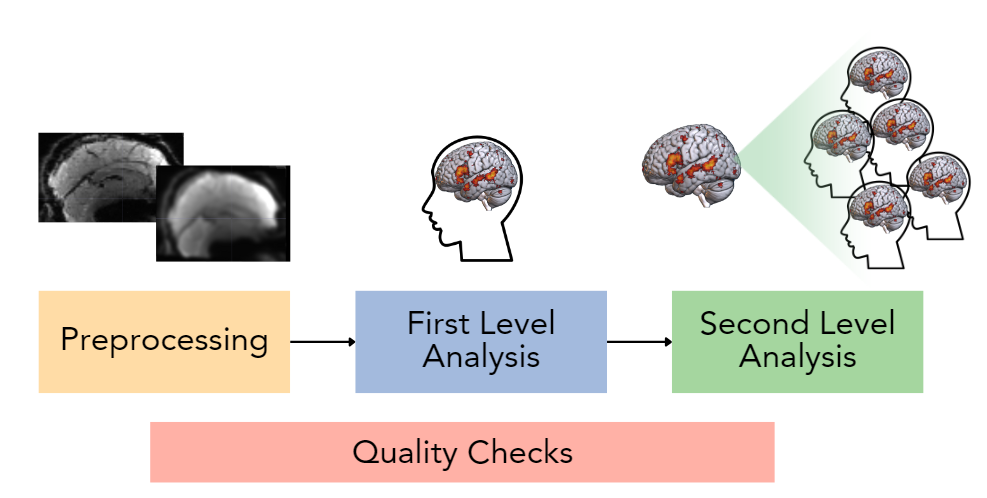

#### Questions

- How to make statistical inference on a single-subject level?


#### Objective

- Learn to create statistical maps using a mass univariate approach

## Install dependencies and data

In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 25.1 MB/s eta 0:00:00


For illustration purposes, we will use a dataset that comes with Nilearn (check out the documentation of the [```datasets```](https://nilearn.github.io/stable/modules/datasets.html) submodule for other available datasets).

The dataset includes the functional data of a single subject who completed the tasks described in [Pinel et al. (2007)](https://doi.org/10.1186/1471-2202-8-91). In their study, participants had to perform basic operations such as pressing a button with the left or right hand, reading and listening to short sentences or viewing horizontal and vertical checkerboards.

In [2]:
from nilearn.datasets import func
data = func.fetch_localizer_first_level()


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/localizer_first_level



Downloaded 18259968 of 34532740 bytes (52.9%,    0.9s remaining) ...done. (4 seconds, 0 min)
Extracting data from /root/nilearn_data/localizer_first_level/62d16779cfae29f3623d6a194141d263/download..... done.


Below we list the files that come with the Nilearn dataset. We have one preprocessed functional image (normalized to the MNI template), and one table (```.tsv```) which is specifying the experimental paradigm.

In [ ]:
!ls /root/nilearn_data/localizer_first_level/localizer_first_level

sub-12069_task-localizer_events.tsv
sub-12069_task-localizer_space-MNI305.nii.gz


A good first step is always to load in the data, check the shape of it and plot the image

In [3]:
import nibabel as nib

func = nib.load("/root/nilearn_data/localizer_first_level/localizer_first_level/sub-12069_task-localizer_space-MNI305.nii.gz")
print(func.shape)

(53, 63, 46, 128)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



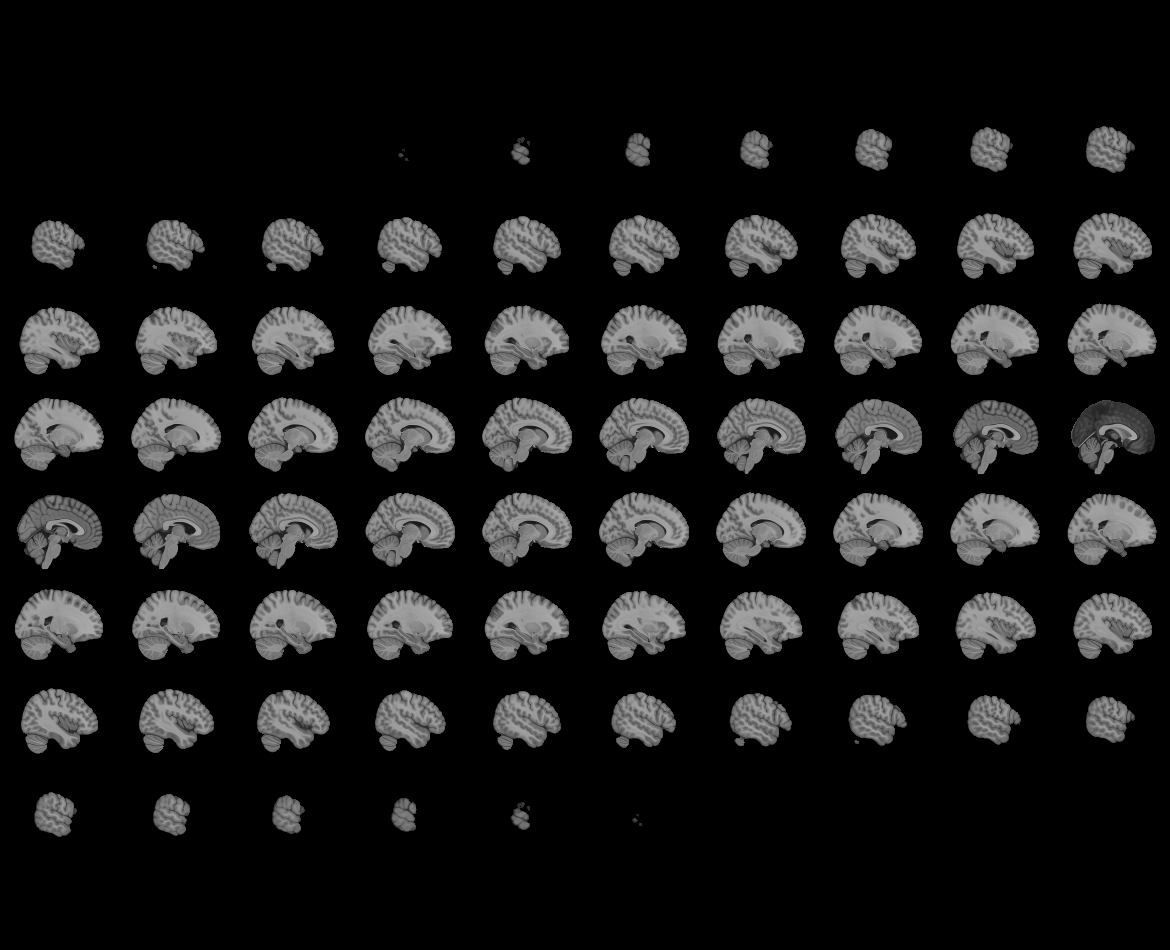
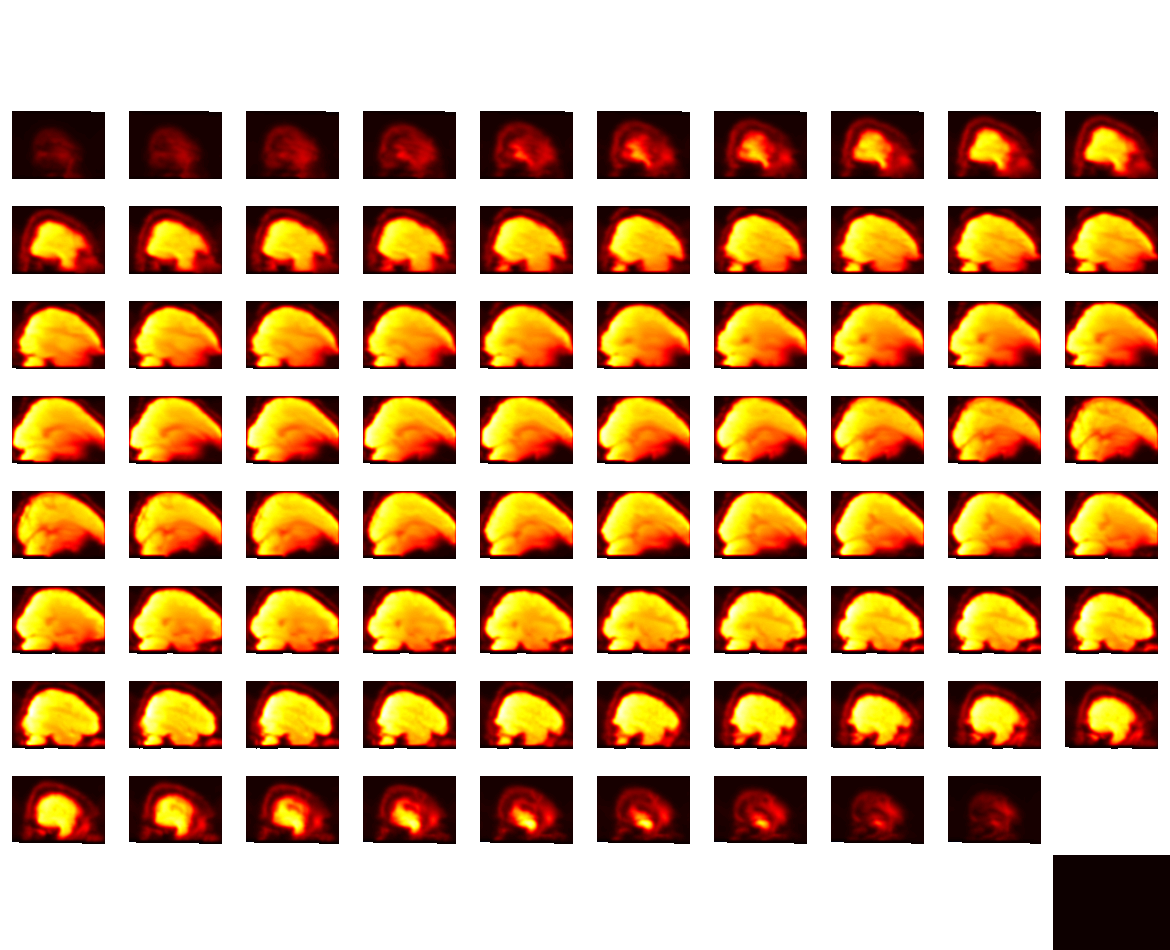

In [4]:
from nilearn import plotting, image

plotting.view_img(image.mean_img(func))

As you can see, the `view_img` function allows us to scroll through the brain!

## Defining the experiment

The BIDS standard specifies that for each run and for each subject the dataset has to include a file specifying the timing and other properties of events that took place in the respective run - the **`events.tsv`** file (see the [BIDS](https://bids-specification.readthedocs.io/en/stable/04-modality-specific-files/05-task-events.html) documentation).

This file always has to include information regarding the time of the **onset** of the stimulus/condition, and its **duration**. It also includes further information regarding the experimental paradigm (such as **trial type**)

Let's have a look at the ```.tsv``` file of our dataset:

In [5]:
import pandas as pd

events = pd.read_table("/root/nilearn_data/localizer_first_level/localizer_first_level/sub-12069_task-localizer_events.tsv")

# have a quick look at the data
print(events.head(5))
print(events.tail(5))

                      trial_type  onset  duration
0             visual_computation    0.0       1.0
1             visual_computation    2.4       1.0
2        horizontal_checkerboard    8.7       1.0
3  audio_right_hand_button_press   11.4       1.0
4             sentence_listening   15.0       1.0
                        trial_type       onset  duration
75              sentence_listening  284.399994       1.0
76                sentence_reading  288.000000       1.0
77  visual_right_hand_button_press  291.000000       1.0
78              sentence_listening  293.399994       1.0
79              sentence_listening  296.700012       1.0


The experiment paradigm of our sample datasets includes 10 different conditions:

In [6]:
print(events.trial_type.unique())

['visual_computation' 'horizontal_checkerboard'
 'audio_right_hand_button_press' 'sentence_listening'
 'visual_right_hand_button_press' 'audio_left_hand_button_press'
 'visual_left_hand_button_press' 'vertical_checkerboard'
 'audio_computation' 'sentence_reading']


Thanks to the ```.tsv``` file we know when and for how long a given condition takes place in the experiment. This way, we can relate it to the timecourse of our fMRI data - using a general linear model (GLM)!


## GLM

The basic idea of the GLM in the context of fMRI data is to predict the BOLD response of a given voxel in response to different experimental conditions (for example: how does the BOLD response change in a V1 voxel if we present some stimulus in our experiment?).

For more detailed information, refer to the lecture slides.

### Specifying the Model

To predict the voxels timecourses we will specify a general linear model using Nilearn's ```FirstLevelModel``` class:

In [7]:
from nilearn.glm.first_level import FirstLevelModel

In [9]:
help(FirstLevelModel)

Help on class FirstLevelModel in module nilearn.glm.first_level.first_level:

class FirstLevelModel(nilearn.glm._base.BaseGLM)
 |  FirstLevelModel(t_r=None, slice_time_ref=0.0, hrf_model='glover', drift_model='cosine', high_pass=0.01, drift_order=1, fir_delays=[0], min_onset=-24, mask_img=None, target_affine=None, target_shape=None, smoothing_fwhm=None, memory=Memory(location=None), memory_level=1, standardize=False, signal_scaling=0, noise_model='ar1', verbose=0, n_jobs=1, minimize_memory=True, subject_label=None, random_state=None)
 |  
 |  Implement the General Linear Model for single run :term:`fMRI` data.
 |  
 |  Parameters
 |  ----------
 |  t_r : float
 |      This parameter indicates :term:`repetition times<TR>`
 |      of the experimental runs.
 |      In seconds. It is necessary to correctly consider times in the design
 |      matrix. This parameter is also passed to :func:`nilearn.signal.clean`.
 |      Please see the related documentation for details.
 |  
 |  slice_time_

As can be seen in the documentation, we need to provide the **repetition time** (```t_r```) of our functional scans, i.e., the time it takes to scan one volume. This parameter is important as it implies at which point in time we have sampled the voxels responses.

Normally in a BIDS dataset, the repetition time is specified in a ```.json``` file or included in the header. For this dataset, however, we have to set the repitition time manually (which can be found in Pinel et al. (2007)).

In [10]:
tr = 2.4

Using the repition time, we can now setup our linear model using the ```FirstLevelModel``` class. In this step, we specify which **hemodynamic reponse function (HRF)** to use. Here, we will use SPM's default function, but we could also include further time derivatives as regressors (see documentation). Also, we will set a high pass filter (removing signals below that threshold) und use the default drift model (to account for signal drift in the course of the experiment).

In [14]:
first_level = FirstLevelModel(t_r=tr,
                              slice_time_ref = 0,
                              hrf_model="spm",
                              high_pass=0.009,
                              drift_model="cosine",
                              minimize_memory = False) # for voxelwise attributes like R-Squared)

### Fitting the model to the data

Now that we have specified the model, we can fit our data to it. In this step, we have to provide our events table. This way, the HRF and the timings of the respective conditions are [convolved](https://en.wikipedia.org/wiki/Convolution), resulting in an **ideal time-series** that represents a given voxel's time-series *if* that voxel is responsive to a given condition. Importantly, we are using a mass univariate approach, meaning that we want to model *every* voxel.


Note that in this step, we could also include the motion parameters as further regressors (see the confounds parameter of ```FirstLevelModel```) but they are not included in this dataset. For a tutorial where motion parameters have been included check the [References & Resources](#References-&-resources) section.

In [16]:
first_level = first_level.fit(image.smooth_img(func, 4), events = events)

The ```.fit``` method yields both the **beta maps** (i.e., the regression weight for each predictor) and the **design matrix** - the statistical model of the data. It contains the ideal time-series for each experimental condition (the predictor variables) as well as some further nuisance regressors (note that the motion parameters would have been included as further predictors).

*Note that since the data has not been smoothed during preprocessing, we are apply smoothing with a kernel width of 4 using Nilearn's ```smooth_img``` function, increasing statistical power*

We can visualize the design matrix using Nilearn:

<Axes: label='conditions', ylabel='scan number'>

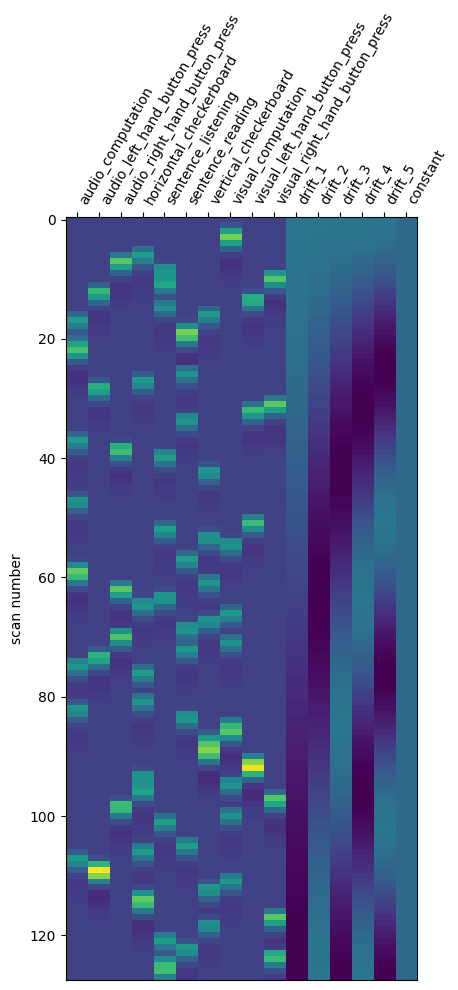

In [19]:
design_matrix = first_level.design_matrices_[0]
plotting.plot_design_matrix(design_matrix)

In [20]:
print(design_matrix.shape)

(128, 16)


As you can see, the design matrix consists of 16 columns, representing the predictors (12 experimental conditions). The rows indicate the observations, i.e., points in the time-series. Each column consists of the ideal time-series for the respective conditions (go back to the events file and see if it makes sense to you)

Let's plot the first column (representing the ideal time-series for the audio computation time-series):

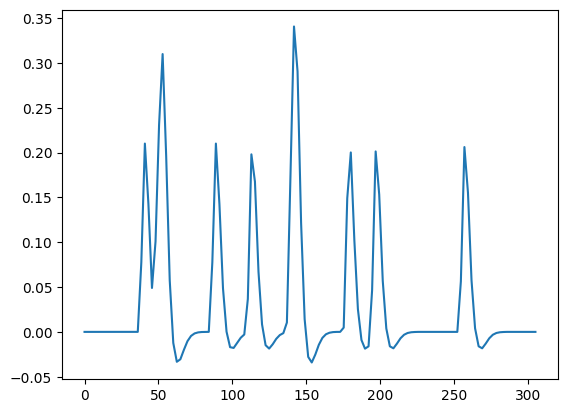

In [21]:
import matplotlib.pyplot as plt

plt.plot(design_matrix["audio_computation"])

Now, how did we get here? Where does this time-series come from? Remember that we specified the **hemodynamic response function (HRF)**. I will show you what happens when we specify not to use any HRF.

<Axes: label='conditions', ylabel='scan number'>

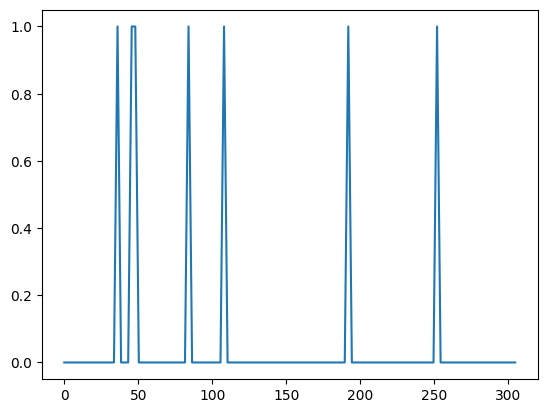

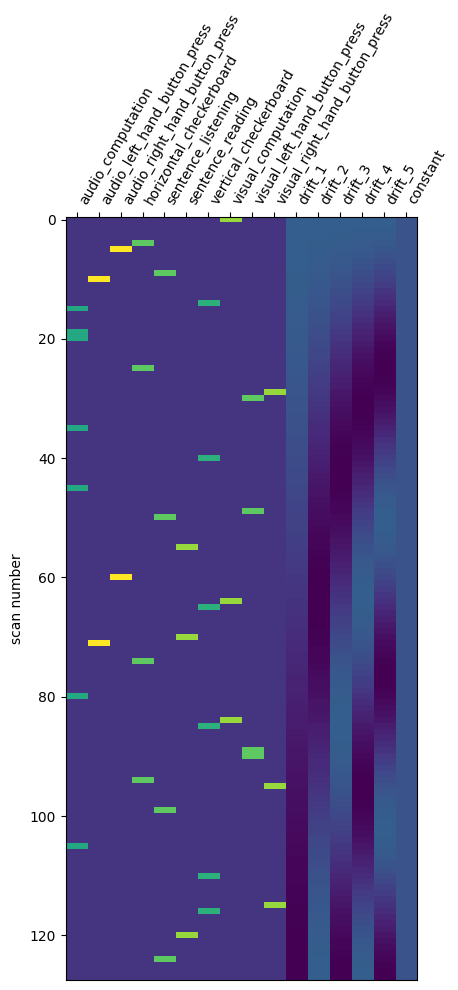

In [24]:
first_level_no_hrf = FirstLevelModel(t_r=tr,
                              slice_time_ref = 0,
                              hrf_model=None,  # THIS IS THE ONLY DIFFERENCE
                              high_pass=0.009,
                              drift_model="cosine",
                              minimize_memory = False)

first_level_no_hrf = first_level_no_hrf.fit(image.smooth_img(func, 4), events = events)
design_matrix_no_hrf = first_level_no_hrf.design_matrices_[0]
plt.plot(design_matrix_no_hrf["audio_computation"])
plotting.plot_design_matrix(design_matrix_no_hrf)

### Contrasts: comparing experimental conditions


Now, if we want to know which voxels respond more/less/differently to a certain condition than to another condition (or baseline), we have to compute **contrasts** - the difference in beta estimates between conditions. When we are talking about brain areas that show more activation, "more activation" is always meant in relation to something else - even if it is the "baseline" or the fixation cross.

To calculate a contrast, we have to assign weights to each **Beta** (i.e., each predictor -> design matrix column).

In the following we want to check
- which voxels show more/less activity in the sentence listening condition compared to the baseline
- which voxels are more/less active when pressing a button with the right hand compared to pressing it with the left hand
- which voxels are more active during conditions involving predominantly visual operations compared to the baseline

In [25]:
import numpy as np

conditions = {
  "sentence_listening > baseline":  np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  "right > left":                   np.array([0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0]),
  "avg_visual":                     np.array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])
}

We have to assign a weight to each predictor of our design matrix. Thus the array to specify a contrast has a length of 16.

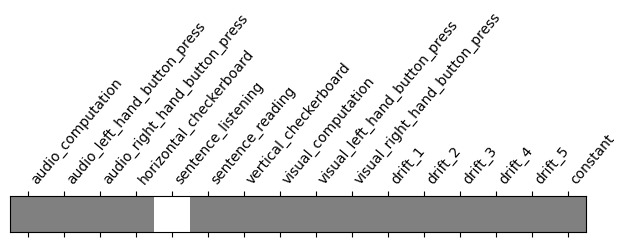

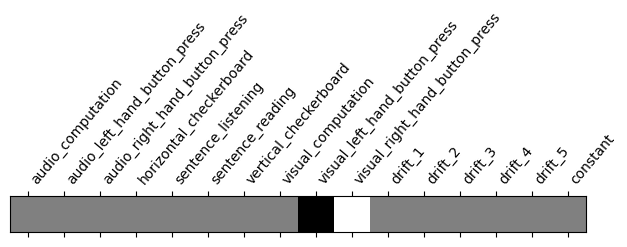

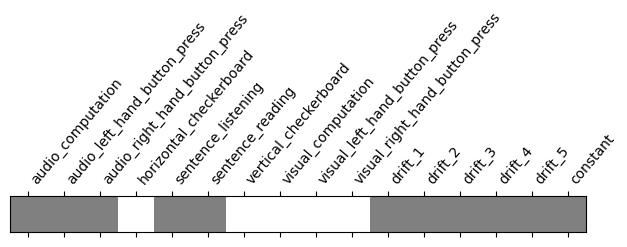

In [26]:
for id, val in conditions.items():
  plotting.plot_contrast_matrix(val, design_matrix=design_matrix)

Above, we defined the contrasts manually (i.e., setting the weights ourselves). However, Nilearn also allows us to define simple contrasts with verbal labels (i.e., the design matrix column labels):

<Axes: label='conditions'>

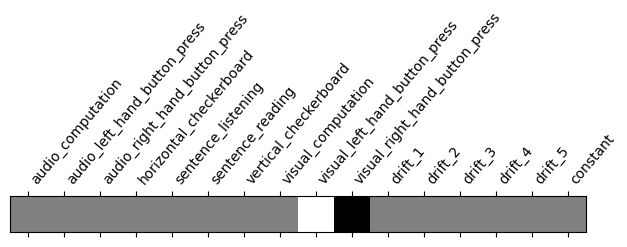

In [27]:
plotting.plot_contrast_matrix("visual_left_hand_button_press - visual_right_hand_button_press",
                              design_matrix=design_matrix)

Now that we have defined the contrasts of interest, we can calculate the respective statistics. To investigate statistical significance we will calculate a t-statistic for each voxel and directly convert it into z-scale (we will use the ```conditions``` dictionary we defined earlier but you could also use verbal labels as in the cell above):

In [28]:
z_map_right_left = first_level.compute_contrast(conditions["right > left"],
                                                output_type="z_score")

Next, we will display the statistical map on top of the MNI template (this is the default background image of the ```plot_stat_map``` function but we could also use the subject's anatonomy, see the ```bg_img``` parameter). Using the treshold parameter, we also specify that only voxels with an absolute z-value larger than 3 will be displayed (this is for illustration purposes only and no proper statistical inference).

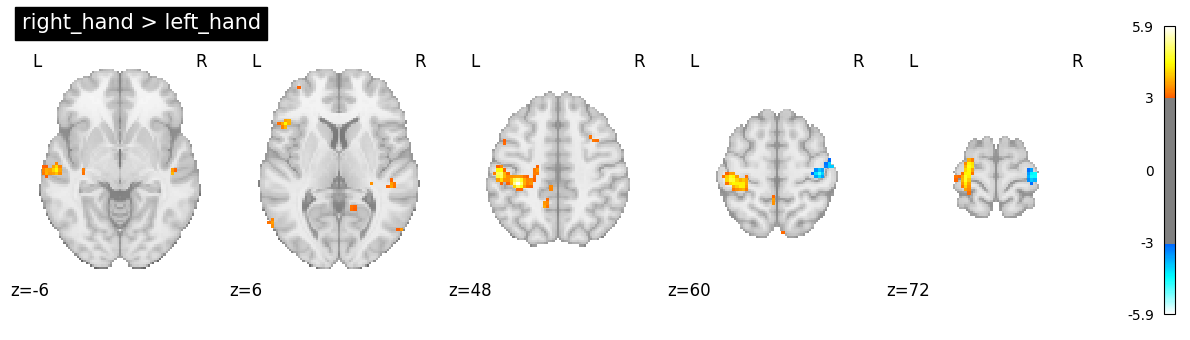

In [29]:
plotting.plot_stat_map(z_map_right_left,
                       display_mode="z",
                       cut_coords=5,
                       threshold = 3.0,
                       title="right_hand > left_hand", symmetric_cbar=True)

As expected, voxels in the motor/somatosensory cortex of the left hemisphere are more active when pressing a button with the right hand. To recap the theory of contrasts: For right>left contrast, we weigh the Betas of the right and left button press condition with 1 and -1, respectively. Consider for example a voxel in the left M1: Say for this voxel, our model estimated a β of 4 for the right button press condition (i.e., high activity) and a β of 0.1 for the left button press condition (almost no activity): We now weigh these β with our [1, -1] contrast (and 0 for all other conditions). That is: $$ 4*1 + 0.1 * -1 = 3.9  $$   

So for this specific voxel in the left M1 we would end up with z-scaled value of 3.9 (i.e., a rather high value -> yellowish dot in the statistical map). This is done for all voxels in the brain (mass univariate approach) and the end result is the statistical map we see above.

Importantly, you can also use such contrasts as a **sanity check**: Think about contrasts between conditions in your experiment where you are certain that a specific region shows a increased BOLD response (e.g. activity in the left motor cortex for a right-hand button press or V1 activity for eyes open vs. eyes closed). If the results don't match you expectations, chances are that something went wrong and you would have to double check your preprocessing pipeline.


#### Correcting for multiple comparisons

So far we haven't tested the voxels' responses for significance yet. For this, we will import another Nilearn function.

A popular way of correcting for multiple comparisons in the context of fMRI data is the [false discovery rate](https://en.wikipedia.org/wiki/False_discovery_rate) which is the expected proportion of false discoveries among detections - again, check the lecture slides or the [Nilearn documentation](https://nilearn.github.io/stable/glm/glm_intro.html#multiple-comparisons) for more information on this. Also, have a look at this nice [notebook on  multiple comparison correction](https://lukas-snoek.com/NI-edu/fMRI-introduction/week_6/MCC.html) created by [Lukas Snoek](https://lukas-snoek.com/) from the University of Amsterdam.

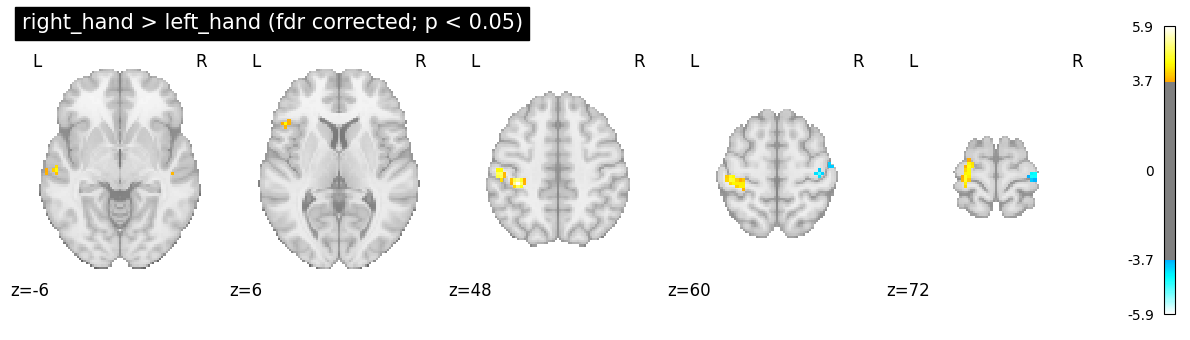

In [30]:
from nilearn.glm.thresholding import threshold_stats_img
_, threshold = threshold_stats_img(z_map_right_left, alpha=.05, height_control='fdr')

plotting.plot_stat_map(z_map_right_left,
                       display_mode="z",
                       cut_coords=5,
                       threshold = threshold,
                       title="right_hand > left_hand (fdr corrected; p < 0.05)")

Now we can apply these steps to all of our defined contrasts using a ```for``` loop:


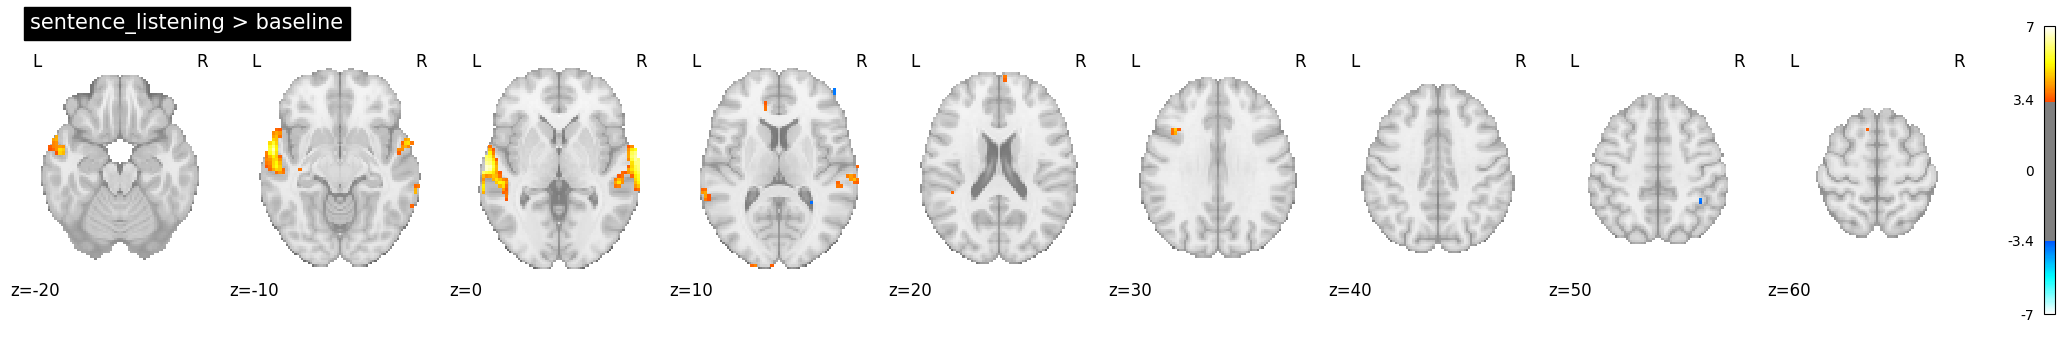

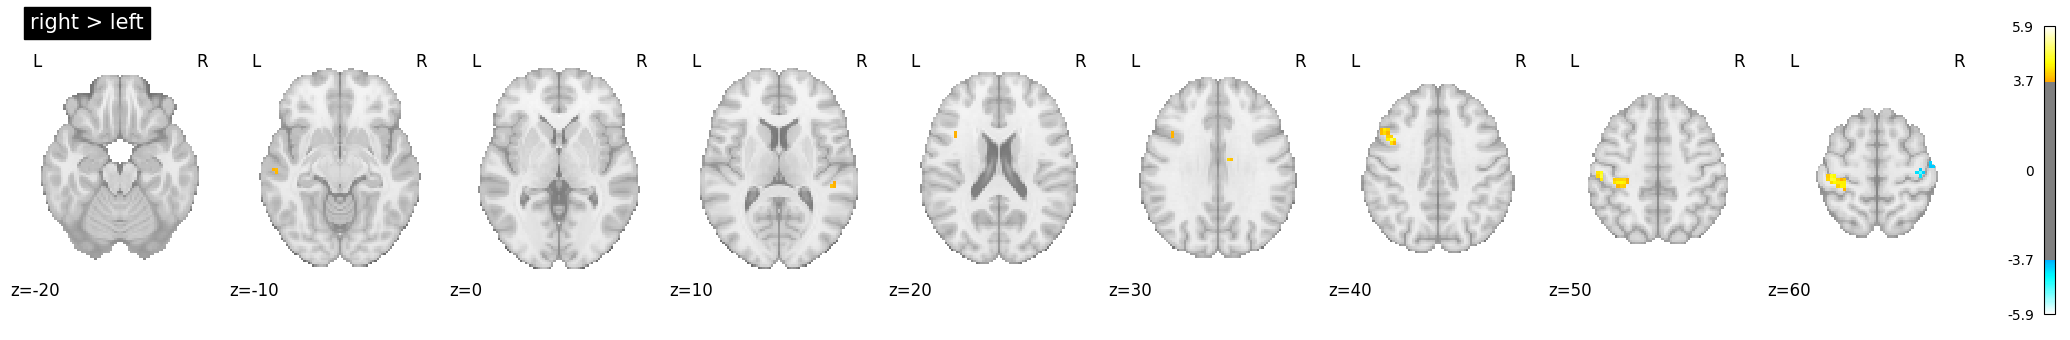

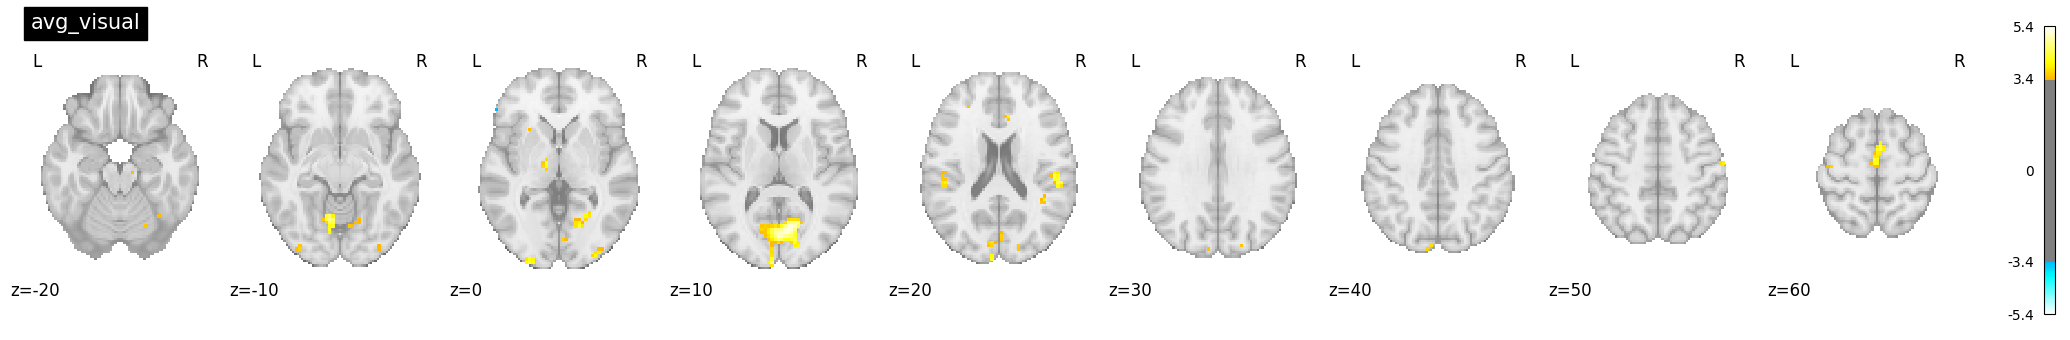

In [31]:
for id, val in conditions.items():

  z_map=first_level.compute_contrast(val, output_type="z_score")
  _, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')

  plotting.plot_stat_map(z_map,
                         display_mode="z",
                         threshold=threshold,
                         cut_coords=range(-20, 70, 10),
                         title=id)

## Reporting

### Automatic reporting using Nilearn

Another way of checking the results of the first level analysis is to inspect the significant clusters of voxels. For this job, Nilearn provides the ```get_clusters_table``` function which will list the clusters with the most activity.

We will set a treshold of 10, so that only clusters with more than 10 voxels will be included in our table (note that this is an arbitrary value and only done here for illustration purposes).

Let's get the cluster statistics for the right hand > left hand contrast:

In [32]:
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.reporting import get_clusters_table

_, threshold = threshold_stats_img(z_map_right_left, alpha=.05, height_control='fdr')

cluster_table = get_clusters_table(z_map_right_left, stat_threshold=threshold,
                                   cluster_threshold=10)

print(cluster_table)



  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1 -36.0 -30.0  48.0   5.929176               4860
1         1a -42.0 -27.0  57.0   5.076876                   
2         1b -51.0 -21.0  48.0   5.006297                   
3         1c -27.0 -24.0  72.0   4.630786                   
4          2 -42.0   9.0  39.0   4.917276                864
5         2a -48.0  18.0  39.0   4.228714                   
6          3 -39.0  12.0  24.0   3.969056                351


Another nice feature of Nilearn is the ```make_glm_report``` function which outputs a HTML report for all important aspects of a fitted GLM:

In [33]:
from nilearn.reporting import make_glm_report
my_glm_report = make_glm_report(first_level, contrasts = conditions,
                                height_control = "fdr", alpha=.05)

my_glm_report

/usr/local/lib/python3.10/dist-packages/nilearn/reporting/utils.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(
/usr/local/lib/python3.10/dist-packages/nilearn/reporting/utils.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(
/usr/local/lib/python3.10/dist-packages/nilearn/reporting/utils.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(


We can inspect the report directly in the notebook or save it as a ```.html``` file using the ```save_as_html()``` method

In [34]:
my_glm_report.save_as_html("my_report.html")

### Adding region labels

Another neat way to automatically generate reports of our results is implemented in the Python package [```atlasreader```](https://github.com/miykael/atlasreader). A cool thing about this tool is that it does not only create nice figures but also adds atlas labels for the cluster peaks.

In this notebook, we only want to extract a cluster table containing the respective atlabs label - thus we import the ```get_statmap_info``` (however, do check the Githup repository of atlasreader to refer to the usage of its main function ```create_output```):

In [35]:
!pip install atlasreader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 51.9 MB/s eta 0:00:00


In [36]:
from atlasreader import get_statmap_info

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [37]:
cluster_info, peak_info = get_statmap_info(z_map_right_left,
                                           cluster_extent = 10)

In [38]:
cluster_info.head(10)

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-42.0,9.0,39.0,2.576836,37125.0,21.75% Frontal_Inf_Tri_L; 18.47% Frontal_Mid_2...,31.20% Unknown; 29.75% Left-Cerebral-White-Mat...,27.49% Left_Middle_Frontal_Gyrus; 12.15% Left_...
1,2.0,-36.0,-30.0,48.0,2.853335,31617.0,37.83% Postcentral_L; 13.92% Precentral_L; 9.5...,41.16% Left-Cerebral-White-Matter; 25.96% Unkn...,45.18% Left_Postcentral_Gyrus; 19.56% Left_Pre...
2,3.0,48.0,-33.0,9.0,2.426138,12771.0,35.73% Temporal_Sup_R; 20.72% SupraMarginal_R;...,39.53% Right-Cerebral-White-Matter; 27.48% Unk...,25.37% Right_Supramarginal_Gyrus_posterior_div...
3,4.0,-57.0,-18.0,-6.0,2.55487,7290.0,60.74% Temporal_Mid_L; 19.63% Temporal_Sup_L; ...,34.81% Unknown; 21.85% Left-Cerebral-White-Mat...,42.59% Left_Middle_Temporal_Gyrus_posterior_di...
4,5.0,39.0,-42.0,-30.0,2.470239,6507.0,39.83% Temporal_Inf_R; 24.48% Fusiform_R; 15.7...,41.08% Unknown; 15.77% ctx-rh-inferiortemporal...,34.44% Right_Inferior_Temporal_Gyrus_posterior...
5,6.0,39.0,-21.0,60.0,-3.017061,5427.0,77.61% Precentral_R; 18.41% Postcentral_R,40.30% Unknown; 23.38% Right-Cerebral-White-Ma...,59.70% Right_Precentral_Gyrus; 39.30% Right_Po...
6,7.0,-54.0,-15.0,15.0,2.394432,5130.0,42.11% Temporal_Mid_L; 26.32% Temporal_Sup_L; ...,34.74% Unknown; 20.53% Left-Cerebral-White-Mat...,16.84% Left_Central_Opercular_Cortex; 16.32% L...
7,8.0,-36.0,57.0,3.0,2.364154,2970.0,56.36% Frontal_Mid_2_L; 33.64% no_label; 7.27%...,64.55% Unknown; 30.91% ctx-lh-rostralmiddlefro...,100.00% Left_Frontal_Pole
8,9.0,15.0,15.0,9.0,2.375542,1863.0,59.42% Caudate_R; 21.74% Putamen_R; 18.84% no_...,55.07% Right-Caudate; 23.19% Right-Cerebral-Wh...,60.87% Right_Caudate; 20.29% Right_Putamen; 15...
9,10.0,-3.0,-18.0,66.0,2.446944,1755.0,32.31% Paracentral_Lobule_L; 32.31% Supp_Motor...,32.31% Unknown; 21.54% Left-Cerebral-White-Mat...,41.54% Left_Precentral_Gyrus; 30.77% Right_Jux...


---

What we did not cover in this notebook are ways to assess the quality of the model fit. For this, you can inspect residuals of the model as well as extract the predicted time series (you need to set ```minimize_memory``` in when initializing the ```FirstLevelModel``` to ```False``` to do so). See [here](https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_predictions_residuals.html#sphx-glr-auto-examples-04-glm-first-level-plot-predictions-residuals-py for a tutorial from the Nilearn user guide

## References & Resources

**Dataset**

Pinel, P., Thirion, B., Meriaux, S. et al. Fast reproducible identification and large-scale databasing of individual functional cognitive networks. *BMC Neuroscience*, *91* (2007). https://doi.org/10.1186/1471-2202-8-91

Notter M. P., Gale D., Herholz P., Markello R. D., Notter-Bielser M.-L., & Whitaker K. (2019). AtlasReader: A Python package to generate coordinate tables, region labels, and informative figures from statistical MRI images. *Journal of Open Source Software, 4(34), 1257*, [https://doi.org/10.21105/joss.01257](https://doi.org/10.21105/joss.01257)


---


**Tutorials covering First-Level analysis in Python:**


[Nilearn User Guide on First-Level models](https://nilearn.github.io/stable/glm/first_level_model.html)


[Nilearn statistical analysis tutorial](https://github.com/miykael/workshop_pybrain/blob/master/workshop/notebooks/04b_statistical_analyses_MRI.ipynb) & corresponding [Youtube tutorial](https://youtu.be/4FVGn8vodkc?t=15105)
- includes both first and second level analysis
- covers further concepts, such as inclusion of motion parameters, F-tests or model evaluation

[Nilearn documentation: GLM First Level](https://nilearn.github.io/auto_examples/04_glm_first_level/plot_first_level_details.html#sphx-glr-auto-examples-04-glm-first-level-plot-first-level-details-py)
- same dataset as in this notebook, but more in-depth
- data masking, changing the HRF function, adjusting the drift model

Below, there also two more in-depth tutorials covering the First-Level analysis within Python, however, with "manual" model specification and fitting (i.e., without the help of Nilearn).

https://lukas-snoek.com/NI-edu/fMRI-introduction/week_2/glm_part1_estimation.html

https://lukas-snoek.com/NI-edu/fMRI-introduction/week_3/glm_part2_inference.html
